# Facial Verification


Facial verification involves confirming a person's identity using a reference photo. For example, a company can store a photo of each employee in a database. When an employee presents their badge at the entrance, the system compares their photo with the stored one to verify their identity.


This task presents several challenges:
- We don't always have access to many photos of each employee for training.
- It's preferable to avoid retraining the model every time a new employee joins the company.


To address this issue, we will use the method described in the article [Learning a Similarity Metric Discriminatively, with Application to Face Verification](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=1467314). This method trains a similarity measure from the data.

It is particularly effective for datasets containing a large number of categories (each person is a category for faces) and/or when not all categories are available during training (new employee).


Let's start by analyzing some theoretical points from the article to understand how the method works, then we will move on to the implementation.


## Theoretical Analysis of the Article


### Intuition


The main idea of the article is to train the model contrastively on pairs of images. Two scenarios are possible:
- Both images come from the same category.
- Both images come from different categories.

The goal is to have a model $G_w$ that maps an image into a latent space where the Euclidean (or cosine) distance effectively differentiates the elements.

More formally, we want:
$D_W(X_1,X_2) = \lVert G_W(X_1) - G_W(X_2)\rVert $ to be small if $X_1$ and $X_2$ are in the same category and large if they are in different categories.


The model is trained on pairs of images, and the weights of $G_W$ are shared.

The architecture looks like this:

![siamese2](./images/siamese2.png)


### Contrastive Loss Function


How do we define our loss function for this objective? Let $Y$ be the label of our image pair. If $Y$ is 0, the images come from the same category; otherwise, $Y$ is 1.

The contrastive loss function is expressed as follows:
$L(Y,X_1,X_2)= (1-Y)\frac{1}{2}(D_W)^2 + (Y)\frac{1}{2}(max(0,m-D_W))²$

This function may seem complex, but it is actually quite simple. Let's examine the two possible values of $Y$:
- If $Y = 0$, then $L(Y,X_1,X_2)= \frac{1}{2}(D_W)^2$, which simply corresponds to the distance $D_W$ defined earlier.
- If $Y = 1$, then $L(Y,X_1,X_2)= \frac{1}{2}(max(0,m-D_W))²$. This part requires further explanation. One might assume that simply using $\frac{1}{D_W}$ would maximize the distance (which we want). In practice, this doesn't work because the model could learn to separate elements with a very small margin, which could cause generalization issues. The parameter $m$ (margin) allows specifying a minimum separation margin between different elements. This makes the model more robust and stabilizes training.

**Note**: Why not simply minimize $D_W(X_1,X_2)$ on pairs of images from the same category only? If we do this, the model can "collapse" and learn a trivial solution that makes $G_W$ a constant function, so the loss will always be 0. In practice, the model will always seek the simplest solution, so we must carefully define our loss functions to prevent the model from finding a trivial shortcut.


### Model Architecture and Training


$G_W$ can be any neural network. The article suggests using a convolutional network for its capabilities with images and its robustness to geometric distortions (common in facial verification).

We will not strictly reproduce the architecture of the article, but rather design our own architecture and train it on a more substantial dataset than those in the article.

For training, the article recommends using 50% positive pairs and 50% negative pairs.


## Implementation


In [15]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

It's time to implement our model!


### Dataset


We use the [LFW](https://vis-www.cs.umass.edu/lfw/) dataset, which contains 13,233 images of 5,749 people, with 1,680 having at least 2 images (necessary for positive examples). We use [LFWPairs](https://pytorch.org/vision/main/generated/torchvision.datasets.LFWPairs.html) from torchvision, which already groups images into positive or negative pairs in equal proportions.


In [100]:
transform = T.Compose([
    T.ToTensor(),
    T.Resize((128,128)), # On réduit la taille des images pour accélérer l'entraînement
])
train_data=datasets.LFWPairs(root='./../data',download=False,split= 'train',transform=transform)
test_data=datasets.LFWPairs(root='./../data',download=False,split= 'test',transform=transform)

Nombre de paires pour le training:  2200
Nombre de paires pour le test: 1000
Taille image torch.Size([3, 128, 128])


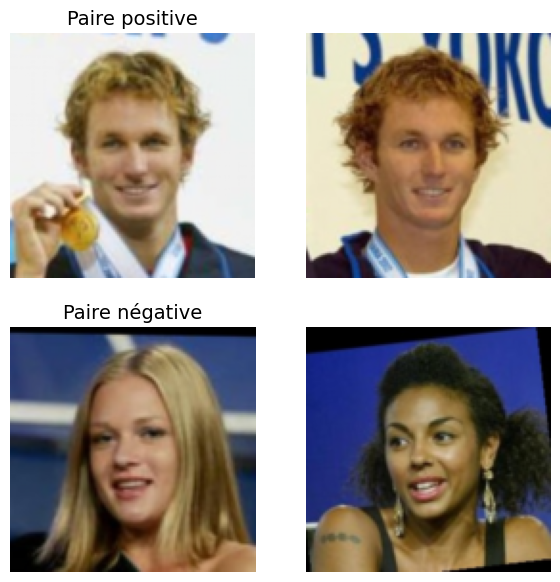

In [101]:
print('Nombre de paires pour le training: ',len(train_data))
print('Nombre de paires pour le test:',len(test_data))
print('Taille image',train_data[0][0].shape)

fig, axs = plt.subplots(2, 2, figsize=(7, 7))

axs[0, 0].imshow(train_data[0][0].permute(1, 2, 0))
axs[0, 0].axis('off')

axs[0, 1].imshow(train_data[0][1].permute(1, 2, 0))
axs[0, 1].axis('off')
for data in train_data:
  if data[2]==0:
    axs[1, 0].imshow(data[0].permute(1,2,0))
    axs[1, 0].axis('off')
    axs[1, 1].imshow(data[1].permute(1,2,0))
    axs[1, 1].axis('off')
    break
axs[0, 0].set_title("Paire positive", fontsize=14, ha='center')
axs[1, 0].set_title("Paire négative", fontsize=14, ha='center');


Note that in the dataset, $Y=1$ corresponds to a positive pair while $Y=0$ corresponds to a negative pair. This is the opposite of the article's notation. We will invert this for clarity.


In [102]:
# On ne peut pas modifier les données directement, on doit les transformer en listes
# Pour les données de training
train_data_list = [list(data) for data in train_data]
for data in train_data_list:
    data[2] = 1 - data[2]
train_data = [tuple(data) for data in train_data_list]

# Pour les données de test
test_data_list = [list(data) for data in test_data]
for data in test_data_list:
    data[2] = 1 - data[2]
test_data = [tuple(data) for data in test_data_list]

We can now create our dataloaders:


In [103]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

### Contrastive Loss Function


It's time to define our loss function. For this, we will simply reuse the formula we introduced earlier. For $D_W$, we take the Euclidean distance:
$D_W (X_1,X_2) = \lVert X_1 - X_2 \rVert_2 = \sqrt{\sum_{i=1}^{n} (X_{1,i} - X_{2,i})^2}$


In [104]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Distance euclidienne entre les deux sorties du réseau
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        
        # Calcul du loss contrastif
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        
        return loss_contrastive

### Creating Our Model


For this task, we will build a classic and relatively small convolutional network. The goal of the model is to project the data into a space where the Euclidean distance is relevant.


In [142]:
class SiameseNetwork(torch.nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Extraction des features pertinentes
        self.conv_net = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        # Projection des features dans un espace de dimension réduite
        self.linear=nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 32), 
            )
    
    def forward(self, x1, x2):
        x1 = self.conv_net(x1)
        x2 = self.conv_net(x2)
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
        x1=self.linear(x1)
        x2=self.linear(x2)
        return x1,x2

### Model Training


Let's define our training hyperparameters:


In [134]:
epochs = 30
lr = 0.001
margin = 1.0
model = SiameseNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion=ContrastiveLoss(margin=margin)

In [135]:
for epoch in range(epochs):
  loss_train = 0
  for x1, x2, label in train_loader:
    x1, x2, label = x1.to(device), x2.to(device), label.to(device)
    optimizer.zero_grad()
    out1, out2 = model(x1, x2)
    loss = criterion(out1, out2, label)
    loss_train+=loss.item()
    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch+1}/{epochs} Loss: {loss_train/len(train_loader)}")

Epoch 1/30 Loss: 0.4855058027998261
Epoch 2/30 Loss: 0.47506297098985617
Epoch 3/30 Loss: 0.44379603841166565
Epoch 4/30 Loss: 0.36472982092612033
Epoch 5/30 Loss: 0.31656959955243097
Epoch 6/30 Loss: 0.3091158025722573
Epoch 7/30 Loss: 0.2988005231903947
Epoch 8/30 Loss: 0.2873344306928524
Epoch 9/30 Loss: 0.28030256138763565
Epoch 10/30 Loss: 0.27428370077108993
Epoch 11/30 Loss: 0.27216234900381253
Epoch 12/30 Loss: 0.2714559338662935
Epoch 13/30 Loss: 0.2713507852260617
Epoch 14/30 Loss: 0.27069854628348694
Epoch 15/30 Loss: 0.26960040553324466
Epoch 16/30 Loss: 0.26909896256267163
Epoch 17/30 Loss: 0.2681442526155624
Epoch 18/30 Loss: 0.26780268636302673
Epoch 19/30 Loss: 0.2663887916267782
Epoch 20/30 Loss: 0.26515361407528754
Epoch 21/30 Loss: 0.26577359880658163
Epoch 22/30 Loss: 0.266544328543587
Epoch 23/30 Loss: 0.2644324919235879
Epoch 24/30 Loss: 0.26508791971465817
Epoch 25/30 Loss: 0.26529018699690915
Epoch 26/30 Loss: 0.26407808313767117
Epoch 27/30 Loss: 0.264637937796

### Model Evaluation


Now that training is complete, we need to evaluate the model. But how? This is not the type of model we are used to evaluating.

We have our test dataset and can calculate the distances between each pair in this dataset. Thus, we can obtain a similarity score for each element in the test dataset.

**The ROC Curve**: The ROC curve (*Receiver Operating Characteristic*) is a graph that illustrates the performance of a binary classification model (positive or negative in our case) at different decision thresholds. The ROC curve includes the following:
- **X-axis**: the false positive rate (or false alarm rate). This is the number of negative elements incorrectly classified as positive, divided by the total number of negative elements.
- **Y-axis**: the true positive rate (recall or sensitivity). This is the number of positive elements correctly classified as positive, divided by the total number of positive elements.

Each point on the curve represents a different decision threshold for classifying elements.

![roc](./images/roc.png)

Figure extracted from [blogpost](https://sefiks.com/2020/12/10/a-gentle-introduction-to-roc-curve-and-auc/).


To judge the quality of a model, we can calculate the area under the ROC curve (AUROC). In the case of a random classifier, we get an AUROC of 0.5, while for a perfect classifier, the AUROC is 1.

We can calculate it for our model:


In [139]:
from sklearn.metrics import roc_curve, auc

model.eval()
labels = []
distances = []
with torch.no_grad():
    for x1, x2, label in test_loader:
        x1, x2, label = x1.to(device), x2.to(device), label.to(device)
        out1, out2 = model(x1, x2)
        dist = torch.nn.functional.pairwise_distance(out1, out2)
        distances.extend(dist.cpu().numpy())
        labels.extend(label.cpu().numpy())
        
fpr, tpr, thresholds = roc_curve(labels, distances)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc}")


ROC AUC: 0.6163399999999999


We get an AUROC of approximately 0.62, which is really not great. We can also plot the curve to see what it looks like.


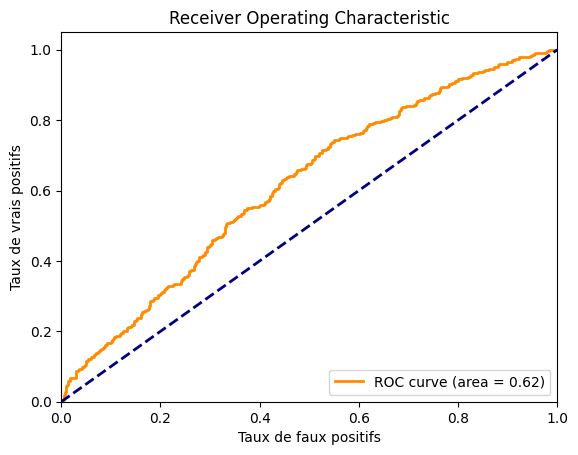

In [141]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

We can see that the model is not very performant. The dataset is probably too complex compared to the size of our model. You can try improving the model's performance by adjusting the architecture and training parameters.


## Triplet Loss


### Facial Recognition


In the field of face processing, there are two main categories: facial verification and facial recognition.

To understand the nuance between the two, let's revisit the case of our company employee:
- **Facial Verification**: In facial verification, an employee wants to enter the building with their badge. They swipe their badge, and the facial verification model checks that it is indeed the employee who owns that badge.
- **Facial Recognition**: Here, imagine the employee goes to the building without their badge, and the model is able to recognize them from the database of all employees to let them in.

As you can imagine, the second task is more complex, whether in terms of pure difficulty or even processing time constraints (we're not going to make the employee wait at the door for an hour while comparing their photo to hundreds of photos in our database).


### FaceNet


For the task of facial recognition, an article [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/pdf/1503.03832) introduced a new type of loss that resembles the contrastive loss. This is the triplet loss, which we will briefly describe.


The goal of this loss is similar to that of the contrastive loss: it aims to learn a representation so that the feature vectors (or *embeddings*) of similar points are brought closer together in the latent space, while those of different points are moved apart.

Unlike the contrastive loss, which is based on pairs of examples, the triplet loss is based on triplets of examples!

Each example has a specific role:
- **Anchor (A)**: The reference example for which we want to learn a representation.
- **Positive (P)**: An example similar to the *anchor* (same person, for example).
- **Negative (N)**: An example different from the *anchor* (a different person).

The loss function is defined as follows:
$L_{\text{triplet}} = \max\left( d(A, P) - d(A, N) + \alpha, 0 \right)$ where $d$ is the distance and $\alpha$ is the margin (*margin*).

This loss minimizes the distance between $P$ and $A$ while maximizing that between $N$ and $A$.

![tripletloss](./images/tripletloss.png)

Figure extracted from the original article.

This may seem redundant with the contrastive loss, and it is somewhat the case. However, the triplet loss has shown better results when it comes to making fine distinctions between quite similar classes (typically the case of facial recognition). Today, its use is preferred over the contrastive loss for face processing tasks.
